In [5]:
using GraphPPL
using Rocket
using ReactiveMP
using Distributions
using Plots
using LinearAlgebra
using Random
using JLD
using Parameters
import ProgressMeter

In [6]:
data_seed, params_seed = 42, 120

(42, 120)

In [7]:
import ReactiveMP.messageout

In [8]:
include("../helpers/data.jl")

generate_data

In [9]:
melu(x) = clamp(x, tiny, Inf)

melu (generic function with 1 method)

In [10]:
# order = 1
Y = zeros(3); Y[1] = 1.0;
U = zeros(3); U[2] = 1.0;
H = zeros(3); H[3] = 1.0;

In [37]:
# Nonlinear MAX model definition
@model [default_factorisation=MeanField()] function nonlinear_max(n, model_flow::FlowModel, params, h_prior, y_prev, u)
    
    dimension = length(h_prior[1])

    # Extract parameters for flow, neural network and Gamma
    del = nr_params(model_flow)
    params_flow = params[1:del]
    params_w = params[end-1:end]
    
    # initialize variables
    h       = randomvar(n)
    hy      = randomvar(n)
    hyu     = randomvar(n)
    Ys      = randomvar(n)
    Us      = randomvar(n)
    θ       = randomvar() where {form_constraint = FixedMarginalConstraint(NormalMeanPrecision(0.0, 1e12))}  
    w       = randomvar() where {form_constraint = FixedMarginalConstraint(GammaShapeRate(melu(params_w[1]), melu(params_w[2])))}
    y       = datavar(Float64, n)

    ar_nodes = Vector{FactorNode}(undef, n)
    y_nodes = Vector{FactorNode}(undef, n)

    y_lat_1 = randomvar(n)
    y_lat_2 = randomvar(n)
    y_lat_3 = randomvar(n)
    
#     Ys = [Y*y_prev[i] for i in 1:n]
#     Us = [U*u[i] for i in 1:n]

    # create meta for AR
    AR_meta = ARMeta(Univariate, 1, ARsafe())
    # create meta compile flow model
    Flow_meta  = FlowMeta(compile(model_flow, params_flow)) # default: FlowMeta(model, Linearization())
    h_0 ~ NormalMeanPrecision(h_prior[1], h_prior[2])

    θ   ~ NormalMeanPrecision(0.0, 1e12)
    w   ~ GammaShapeRate(melu(params_w[1]), melu(params_w[2]))
    
    h_prev = h_0
    for t in 1:n
        # specify latent state
        ar_nodes[t], h[t] ~ AR(h_prev, θ, w) where {q = q(y, x)q(γ)q(θ), meta = AR_meta}
        Ys[t] ~ MvNormalMeanPrecision(Y*y_prev[t], 1e12*diageye(3))
        Us[t] ~ MvNormalMeanPrecision(U*u[t], 1e12*diageye(3))
        hy[t] ~ H*h[t] + Ys[t]
        hyu[t] ~ hy[t] + Us[t]
        y_lat_1[t] ~ Flow(hyu[t]) where { meta = Flow_meta}
        y_lat_2[t] ~ dot(y_lat_1[t], ones(dimension*3))
        y_nodes[t], y[t] ~ NormalMeanPrecision(y_lat_2[t], w)
        h_prev = h[t]
    end

    return h, hy, hyu, θ, w, y_lat_1, y_lat_2, y, y_nodes
end

nonlinear_max (generic function with 1 method)

In [38]:
function nonlinear_max_inference(observations, observations_prev, controls, model_flow::FlowModel, params; 
                                 h_prior=(0.0, 0.1), vmp_its=10)
    # fetch number of samples
    n = length(observations)

    # define model
    model, (h, hy, hyu, θ, w, y_lat_1, y_lat_2, y, y_nodes) = nonlinear_max(n, model_flow, params, h_prior,
                                                                       observations_prev, controls,
                                                                       options = (limit_stack_depth = 500, ))
    
    h_buffer = Vector{Marginal}(undef, n)
    hy_buffer = Vector{Marginal}(undef, n)
    hyu_buffer = Vector{Marginal}(undef, n)
    θ_buffer = Vector{Marginal}(undef, n)
    y_out_buffer = Vector{AbstractMessage}(undef, n)
    w_buffer = nothing
    
    h_sub = subscribe!(getmarginals(h), (x) -> copyto!(h_buffer, x))
    hy_sub = subscribe!(getmarginals(h), (x) -> copyto!(hy_buffer, x))
    w_sub = subscribe!(getmarginal(w), (x) -> w_buffer = x)
    θ_sub = subscribe!(getmarginal(θ), (x) -> θ_buffer = x)
    y_out_sub = subscribe!(collectLatest(messageout.(ReactiveMP.getinterface.(y_nodes, :out))), 
                                         (x) -> copyto!(y_out_buffer, ReactiveMP.as_message.(x)))
    
    # initialize free energy
    fe_buffer = Vector()
    
    # subscribe
    fe_sub = subscribe!(score(BetheFreeEnergy(), model), (f) -> push!(fe_buffer, f))
    
    params_w = params[end-1:end]
    setmarginal!(w, GammaShapeRate(melu(params_w[1]), melu(params_w[2])))
    setmarginal!(θ, NormalMeanPrecision(0.0, 1.0))
    
    for _ in 1:vmp_its
        ReactiveMP.update!(y, observations)
    end
    
    # unsubscribe
    unsubscribe!(fe_sub)
    unsubscribe!(h_sub)
    unsubscribe!(w_sub)
    unsubscribe!(θ_sub)
    
    # return the marginal values
    return fe_buffer, h_buffer, hy_buffer, hyu_buffer, w_buffer, y_out_buffer, θ_buffer
    
end

nonlinear_max_inference (generic function with 1 method)

In [39]:
# specify flow model
dimension = 3
model_flow = FlowModel(dimension,
    (
        AdditiveCouplingLayer(PlanarFlow()), # defaults to AdditiveCouplingLayer(PlanarFlow(); permute=true)
        AdditiveCouplingLayer(PlanarFlow()),
        AdditiveCouplingLayer(PlanarFlow())
    )
);

In [40]:
Random.seed!(data_seed)

n_samples = 100
u = 3 .* sin.(collect(1:n_samples+10))
y_lat, y_obs, h_gen = generate_data(n_samples, narx, Dict(:order_y=>1, :order_u=>1, :order_e=>1),
                                                     Dict(:er_var=>1e-2, :u=>u));

In [41]:
observations_prev = y_obs[1:end-1]
observations      = y_obs[2:end];
controls          = u[1:end];

In [42]:
train_size = 80
X_train, Y_train, U_train = observations_prev[1:train_size], observations[1:train_size], controls[1:train_size]
X_test, Y_test, U_test = observations_prev[train_size+1:end], observations[train_size+1:end], controls[train_size+1:end];

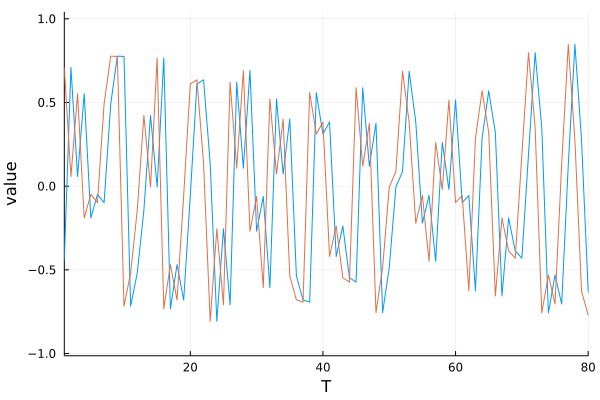

In [43]:
from, to = 1, 80
plot(y_obs, xlims=(1, train_size))
plot!(Y_train, xlims=(from, to), xlabel="T", ylabel="value", legend=false)

In [44]:
Random.seed!(params_seed)

flow_param_len = nr_params(model_flow)
model_params = [randn(flow_param_len); [0.1, 1.0]];

In [45]:
fe_, h_, hy_, hyu_, w_, y_out_, θ_ = nonlinear_max_inference(Y_train, X_train, U_train, model_flow, model_params, vmp_its=5);


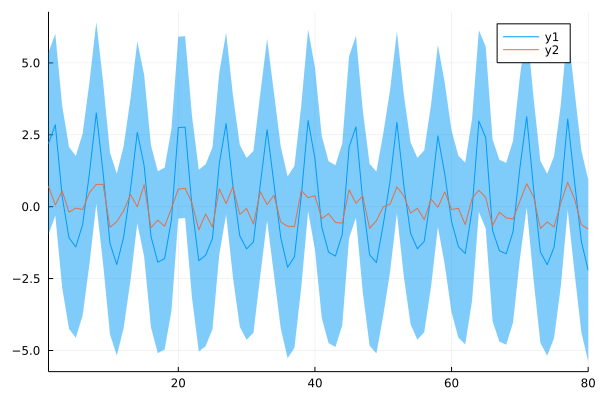

In [46]:
plot(mean.(y_out_), ribbon=sqrt.(cov.(y_out_)))
plot!(Y_train, xlims=(1, 80))

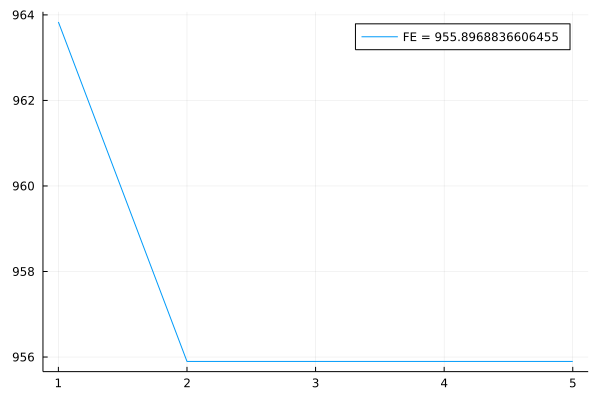

In [47]:
gr()
plot(fe_, label="FE = $(fe_[end])")

In [48]:
# Optimization function
function FE(params)
    fe, h, hy, hyu, w, y_out, θ = nonlinear_max_inference(Y_train, X_train, U_train, model_flow, params, 
                                                 h_prior=(0.0, 0.1), 
                                                 vmp_its=5)
    return fe[end]
end;

In [49]:
FE(model_params)

955.8968836606455

In [75]:
# unpack if you don't want to run Optim
@unpack inf_params = JLD.load("../dump/flow_mle_dataseed_$(data_seed)_paramsseed_$(params_seed).jld")

Dict{String, Any} with 1 entry:
  "inf_params" => [-2.46017, 1.69545, -0.773544, -0.94387, 2.51516, 0.25099, 0.…

In [52]:
import ReactiveMP.fastcholesky
using PositiveFactorizations

function ReactiveMP.fastcholesky(mat::AbstractMatrix)
    return cholesky(PositiveFactorizations.Positive, Hermitian(mat))
end

In [50]:
using Optim
res = optimize(FE, model_params, LBFGS(), Optim.Options(g_tol = 1e-8, iterations = 1000, store_trace = true, show_trace = true, show_every=10), autodiff=:forward)


Iter     Function value   Gradient norm 
     0     9.558986e+02     7.258615e+03
 * time: 0.018934011459350586
    10     1.914637e+02     2.923843e+01
 * time: 15.93552279472351
    20     1.252566e+02     4.779349e+01
 * time: 21.466125965118408
    30     9.975756e+01     5.789060e+01
 * time: 28.03588581085205
    40     9.485426e+01     2.893849e+01
 * time: 62.674712896347046


 * Status: success

 * Candidate solution
    Final objective value:     9.239386e+01

 * Found with
    Algorithm:     L-BFGS

 * Convergence measures
    |x - x'|               = 0.00e+00 ≤ 0.0e+00
    |x - x'|/|x'|          = 0.00e+00 ≤ 0.0e+00
    |f(x) - f(x')|         = 0.00e+00 ≤ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 0.00e+00 ≤ 0.0e+00
    |g(x)|                 = 2.39e+01 ≰ 1.0e-08

 * Work counters
    Seconds run:   159  (vs limit Inf)
    Iterations:    49
    f(x) calls:    639
    ∇f(x) calls:   639


In [51]:
inf_params = Optim.minimizer(res)


20-element Vector{Float64}:
 -3.062923051674519
  2.691908497192453
 -1.5698333151745292
  0.7584514085714779
 -5.155899860941607
  0.2797532778126489
  0.08265533909467852
  0.12738131240289133
  0.9558718968866832
  1.5773722889161976
 -1.4265943066975408
 -0.3915170836002523
  3.3382721767473122
  0.4312386369283477
 -0.7217439433712413
  5.4170355938892545
 -0.943371143496797
  0.05844713267478833
  9.424833689630521
  4.627857008429766

In [55]:
using JLD
JLD.save("../dump/flow_mle_dataseed_$(data_seed)_paramsseed_$(params_seed).jld", "inf_params", inf_params)

In [52]:
FE(inf_params)

94.10324642962587

In [53]:
fe_, h_, hy_, hyu_, w_, y_out_, θ_ = nonlinear_max_inference(Y_train, X_train, U_train, model_flow, inf_params, vmp_its=100);


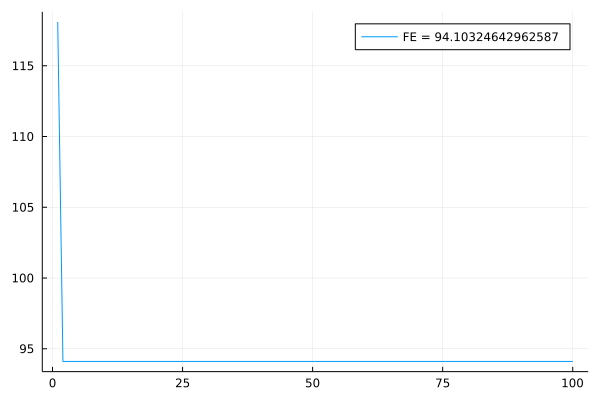

In [54]:
plot(fe_[1:end], label="FE = $(fe_[end])")

In [58]:
from, to = 1, 80

(1, 80)

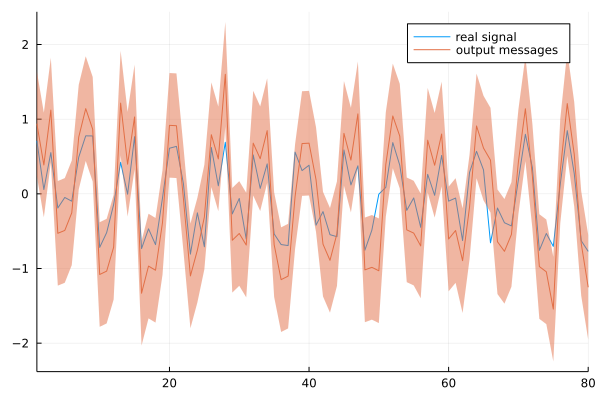

In [59]:
my, vy = mean.(y_out_), cov.(y_out_)
plot(Y_train, xlims=(from, to), label="real signal")
plot!(my, ribbon=sqrt.(vy), label="output messages")

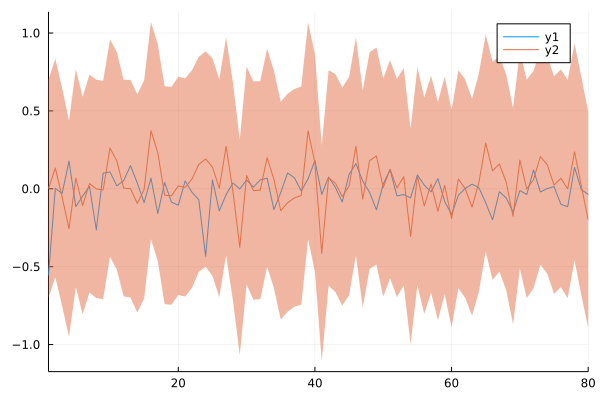

In [60]:
mh, vh = mean.(h_), cov.(h_)
plot(h_gen)
plot!(first.(mh), ribbon=sqrt.(first.(vh)), xlims=(from, to))

### KF-like prediction

In [61]:
function transition(γ, order)
    V = zeros(order, order)
    V[1] = 1/γ
    return V
end

function shift(dim)
    S = Matrix{Float64}(I, dim, dim)
    for i in dim:-1:2
           S[i,:] = S[i-1, :]
    end
    S[1, :] = zeros(dim)
    return S
end

shift (generic function with 1 method)

In [62]:
# Nonlinear MAX model definition
@model [default_factorisation=MeanField()] function nonlinear_max_prediction_model(model_flow::FlowModel, params, w, h_prior, y_prev, u)
    
    dimension = length(h_prior[1])

#     A = shift(dimension) # transition matrix
#     V = transition(w, dimension)

    # initialize variables
    y_pred   = datavar(Float64)
    
    Ys = Y*y_prev
    Us = U*u
    
    del = nr_params(model_flow)
    params_flow = params[1:del]
    params_f = params[del+1:end-2]
    params_w = params[end-1:end]

    h_0 = randomvar() where {form_constraint = FixedMarginalConstraint(NormalMeanPrecision(h_prior[1], h_prior[2]))}

    # compile flow model
    Flow_meta  = FlowMeta(compile(model_flow, params_flow)) # default: FlowMeta(model, Linearization())
    h_0 ~ NormalMeanPrecision(h_prior[1], h_prior[2])
    
#     Ah ~ A*h_0
    h ~ NormalMeanPrecision(h_0, w) where {q = q(h_0, h)q(w)}
    
    hy ~ H*h + Ys
    hyu ~ hy + Us
    
    y_lat_1 ~ Flow(hyu) where { meta = Flow_meta, q = FullFactorisation() }
    
    y_lat_2 ~ dot(y_lat_1, ones(dimension*3))

    y_node, y ~ NormalMeanPrecision(y_lat_2, w) where { q = q(y, y_lat_2)q(w)}
    
    y_pred ~ NormalMeanPrecision(y, 1e-12)
    
    return h, h_0, y_lat_1, y_lat_2, y, y_node, y_pred
end

nonlinear_max_prediction_model (generic function with 1 method)

In [63]:
function nonlinear_max_prediction(observation_prev::T, control::T, model_flow::FlowModel, params; 
                                  h_prior=(ones(2), diageye(2)), w=1.0, vmp_its = 50) where T<:Float64

    # define model
    model, (h, h_0, y_lat_1, y_lat_2, y, y_node, y_pred) = nonlinear_max_prediction_model(model_flow, params, w, h_prior,
                                                                                          observation_prev, control,
                                                                                          options = (limit_stack_depth = 500, ))
    
    h_buffer = nothing
    h0_buffer = nothing
    y_out_buffer = nothing
    y_pred_buffer = nothing
    
    h_sub = subscribe!(getmarginal(h), (x) -> h_buffer = x)
    h0_sub = subscribe!(getmarginal(h_0), (x) -> h0_buffer = x)
    y_pred_sub = subscribe!(getmarginal(y), (x) -> y_pred_buffer = x)

    fe_buffer = Vector()
    
    # subscribe
    fe_sub = subscribe!(score(BetheFreeEnergy(), model), (f) -> push!(fe_buffer, f))
    
    setmarginal!(y, NormalMeanPrecision(0.0, 1.0))
    
    for _ in 1:vmp_its
        ReactiveMP.update!(y_pred, 0.0)
    end
    
    # return the marginal values
    return fe_buffer, h_buffer, h0_buffer, y_pred_buffer
    
end

nonlinear_max_prediction (generic function with 1 method)

In [64]:
predictions = []
h_prev = (mean(h_[end]), precision(h_[end]))
ŵ = mean(w_)
for i in 1:length(X_test)
    fe, h, h_0, y_pred = nonlinear_max_prediction(X_test[i], U_test[i], model_flow, inf_params, h_prior=h_prev, w=ŵ, vmp_its=1)
    push!(predictions, y_pred)
    _, h_inf, _, _, _ = nonlinear_max_inference([Y_test[i]], [X_test[i]], [U_test[i]], model_flow, inf_params, h_prior=h_prev, vmp_its=1);
    h_prev = (mean.(h_inf)[1], precision.(h_inf)[1])
end

In [65]:
mx, vx = mean.(predictions), cov.(predictions)

([-4.558493441257122, 1.0958706867105827, 9.889526581070099, 4.530614304141017, -0.5349264628948125, -5.791885785106473, -5.982866161074038, 0.15767274361878508, 8.073255456155424, 8.23795996067537, -0.2737763474428792, -4.862034309333344, -7.674344856226277, -1.5205992678816902, 4.650259241560004, 10.323526265747397, 1.0022300371874535, -1.4429080257695206, -9.014899650841448, -2.4842972646277586], [8.908407334765728, 0.4913001906617656, 24.42394085992897, 16.581272285437507, 0.5988986458224909, 9.973716823218945, 12.65110625514547, 0.5767891332899396, 26.75665477630735, 22.559585733940448, 1.13522528857896, 13.560711796912406, 14.504012752102062, 0.685665957848011, 14.628321287745532, 25.121827618135484, 1.000752053685794, 3.9785333737669037, 15.808132818185221, 2.5057530634083465])

In [66]:
test_from, test_to = 1, 20

(1, 20)

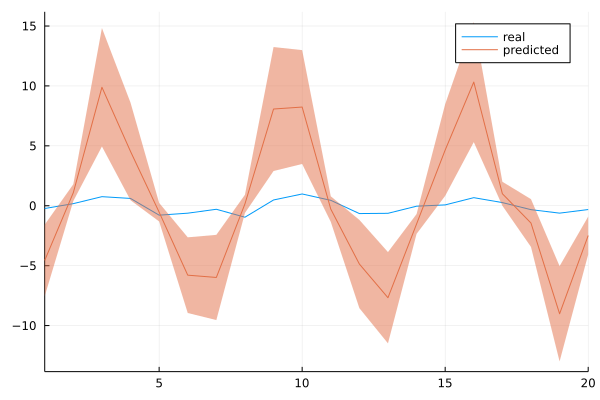

In [67]:
plot(Y_test, label="real")
plot!(mx, ribbon=sqrt.(vx), xlims=(test_from, test_to), label="predicted")